In [4]:
from google.colab import drive  
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')  #matplotlib의 기본 scheme 말고 seaborn scheme 세팅
sns.set(font_scale=2.5)   #seaborn의 font_scale 사용 -> graph의 font size 일일이 지정 필요 없음.

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline 
# notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것 // IPython 에서 제공하는 Rich output(도표, 그림, 소리 등) 에 대한 표현 방식

df_train = pd.read_csv('/content/gdrive/MyDrive/kaggle/week1/train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/kaggle/week1/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 #1은 자기자신
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 #1은 자기자신

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() #'Fare' 칼럼에서 null인 부분은'Fare'의 평균값으로 대체
#df.loc[0] : 전체 데이터 프레임에서 인덱스 이름이 0인 행만 추출
#df.loc[0,'Name'] : 행의 인덱스명이 0, 열의 칼럼명이 'Name'인 곳의 값 추출
#df.iloc[0] : 전체 데이터 프레임에서 0번째 행에 있는 값들만 추출
#df.iloc[0,2] : 0번째 행, 2번 칼럼에 위치한 값 추출 // df.iloc[:5,:5] : 0부터 5번째 행까지, 0부터 5번째 칼럼까지 (총 5x5를 가져와라)

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

# **3. Feature Engineering**

- Feature Engineering은 train뿐만 아니라 test도 똑같이 적용해주어야 함.
- dataset에 존재하는 null data 채울 것 / 이걸 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있음.

# 3.1 Fill Null

**3.1.1 Fill Null in Age using title**

- Age의 null data를 title + statistics를 사용해 채울 것
- title -> Miss, Mr, Mrs를 의미
- pandas series -> str method : data를 sting으로 바꿔줌 // extract method : 정규표현식을 적용하게 해줌.
- 위의 것들을 사용 title을 추출 -> Initial column에 저장할 것 

In [6]:
df_train['Initial']=df_train.Name.str.extract('([A-Za-z]+)\.') #Lets extract the SaLutations

df_test['Initial']=df_test.Name.str.extract('([A-Za-z]+)\.') #Lets extract the SaLutations

- pandas의 crosstab을 이용 -> 추출한 Initial과 Sex 간의 count를 살펴보자

In [7]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위 table 참고, 남자, 여자가 쓰는 initial을 구분해 보자
- replace 메소드 사용하면 특정 데이터 값을 원하는 값으로 치환해 줌

In [8]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [9]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 여성과 관계 있는 Miss, Mrs가 생존률이 높음.

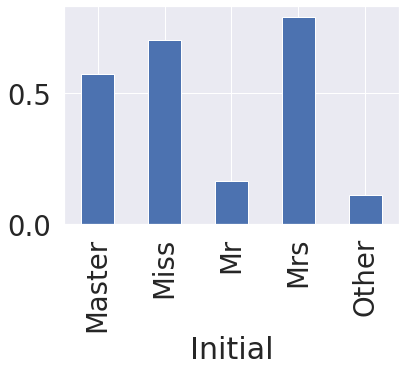

In [10]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- 이제 Null 채울 것
- statistics 활용해서
- statistics 는 train data의 것을 의미 / test는 unseen으로 둬야 함 
- train에서 얻은 statistics 기반으로 test의 null data 채워야 함.

In [11]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- Age의 평균을 이용해 Null value 채울 것
- pandas dataframe을 다룰 때 boolean array 이용해 indexing하면 편리하다
- loc + boolean + column을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해지기

In [12]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33 
#isnull()이면서 Initial이 Mr인 조건을 만족하는 row(탑승객)의 'Age' 값을 33으로 치환한다.
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='other'),'Age'] = 46 
#각 33, 36, 5, 등등은 위에 mean() 표에서 Age에서 직접가져온 숫자임

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33 
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='other'),'Age'] = 46 

**3.1.2 Fill Null in Embarked**

In [13]:
print('Embarked has', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has 2 Null values


- Embarked에서 Null value 2개이고 S에서 가장 많은 탑승객 있었음 -> Null을 S로 채울 것.
- dataframe의 fillna method에서 inplace=True하면 ->  df_train에 fillna를 실제로 적용하게 됨.


In [14]:
df_train['Embarked'].fillna('S', inplace=True)

# 3.2 Change Age (continuos to categorical)

- Age는 현재 continuous feature -> 이대로 모델 세울 수 있으나 -> category화 할것 
- categorical로 바꾸면 자칫 information loss가 생길 수 있으나 다양한 방법 소개를 위해 할 것
- 방법 1 : loc 사용 -> 자주 쓰인다
- 나이는 10살 간격으로 나눌 것

In [15]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age']<10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age'])&(df_train['Age'] < 20), 'Age_cat']=1
df_train.loc[(20 <= df_train['Age'])&(df_train['Age'] < 30), 'Age_cat']=2
df_train.loc[(30 <= df_train['Age'])&(df_train['Age'] < 40), 'Age_cat']=3
df_train.loc[(40 <= df_train['Age'])&(df_train['Age'] < 50), 'Age_cat']=4
df_train.loc[(50 <= df_train['Age'])&(df_train['Age'] < 60), 'Age_cat']=5
df_train.loc[(60 <= df_train['Age'])&(df_train['Age'] < 70), 'Age_cat']=6
df_train.loc[(70 <= df_train['Age']), 'Age_cat']=7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age']<10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age'])&(df_test['Age'] < 20), 'Age_cat']=1
df_test.loc[(20 <= df_test['Age'])&(df_test['Age'] < 30), 'Age_cat']=2
df_test.loc[(30 <= df_test['Age'])&(df_test['Age'] < 40), 'Age_cat']=3
df_test.loc[(40 <= df_test['Age'])&(df_test['Age'] < 50), 'Age_cat']=4
df_test.loc[(50 <= df_test['Age'])&(df_test['Age'] < 60), 'Age_cat']=5
df_test.loc[(60 <= df_test['Age'])&(df_test['Age'] < 70), 'Age_cat']=6
df_test.loc[(70 <= df_test['Age']), 'Age_cat']=7

- 방법 2 : 간단한 함수를 만들어 apply 메소드에 넣어주는 방법
- 훨씬 수월함

In [16]:
def category_age(x):
  if x < 10 :
    return 0
  elif x < 20 :
    return 1
  elif x < 30 :
    return 2
  elif x < 40 :
    return 3
  elif x < 50 :
    return 4
  elif x < 60 :
    return 5
  elif x < 70 :
    return 6
  else:
    return 7

df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

- 두 방법 잘 적용되었으면 둘이 같은 결과를 내야 함 
- 이를 확인하기 위해 Series 간의 boolean 비교 후 all() 메소드 사용
- all() : 모든 값이 True면 True / 하나라도 False면 False 

In [17]:
print('방법 1, 방법 2 둘 다 같은 결과를 내면 True 줘야 함 -> ', (df_train['Age_cat']==df_train['Age_cat_2']).all())

방법 1, 방법 2 둘 다 같은 결과를 내면 True 줘야 함 ->  True


- True 나옴 -> 두 방법 중 아무거나 사용하면 됨
- 중복되는 Age_cat 칼럼과 원래 컬럼 Age를 제거할 것,

In [18]:
df_train.drop(['Age','Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

# 3.3 Change Initial, Embarked and Sex (string to numerical)

- 현재 Initial은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있음.
- 이렇게 카테고리로 표현되어 있는 데이터를 모델에 input으로 넣을 때 -> 수치화 필요
- map method 가지고 간단히 가능
- 시간 순서대로 정리하여 mapping 할 것

In [19]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

- Embarked도 C, Q, S로 이뤄진 것을 map 이용해서 바꿀 것
- unique() : 특정 column에 어떤 값들이 있는 지 확인해보는 방법
- value_counts() : count까지 보는 방법

In [20]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [21]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

- 위 두 방법 사용 -> Embarked가 S, C, Q 세가지로 이루어진 것을 볼 수 있음 
- map 사용해보자

In [22]:
df_train['Embarked'] = df_train['Embarked'].map({'c': 0, 'Q' : 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'c': 0, 'Q' : 1, 'S': 2})

- Null 사라졌는지 확인해보자
- ['Embarked'] : 이 column만 가져온 것 -> 하나의 pandas series 객체
- isnull() : seires의 값들이 null인지 아닌지에 대한 boolean 값을 얻을 수 있다.
- any() : True가 하나라도 있을 경우 ( = Null이 하나라도 있을 경우) True 를 반환 
- 우린 이미 Null을 S로 다 바꿔주었으므로 False 가 반환된다.

In [23]:
df_train['Embarked'].isnull().any()

True

- Sex 도 Female, male -> map 이용해서 바꿔보자

In [24]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

- 각 feature 간의 상관관계를 보자
- 두 변수 간의 Pearson correlation -> (-1,1) 사이의 값 -> -1로 같수록 음의 상관관계 / 0은 상관관계 없음 / 1로 갈수록 양의 상관관계
- heatmap plot : 여러 feature를 하나의 matrix형태로
- dataframe의 corr() 메소드 & seaborn으로 그릴 수 있다.

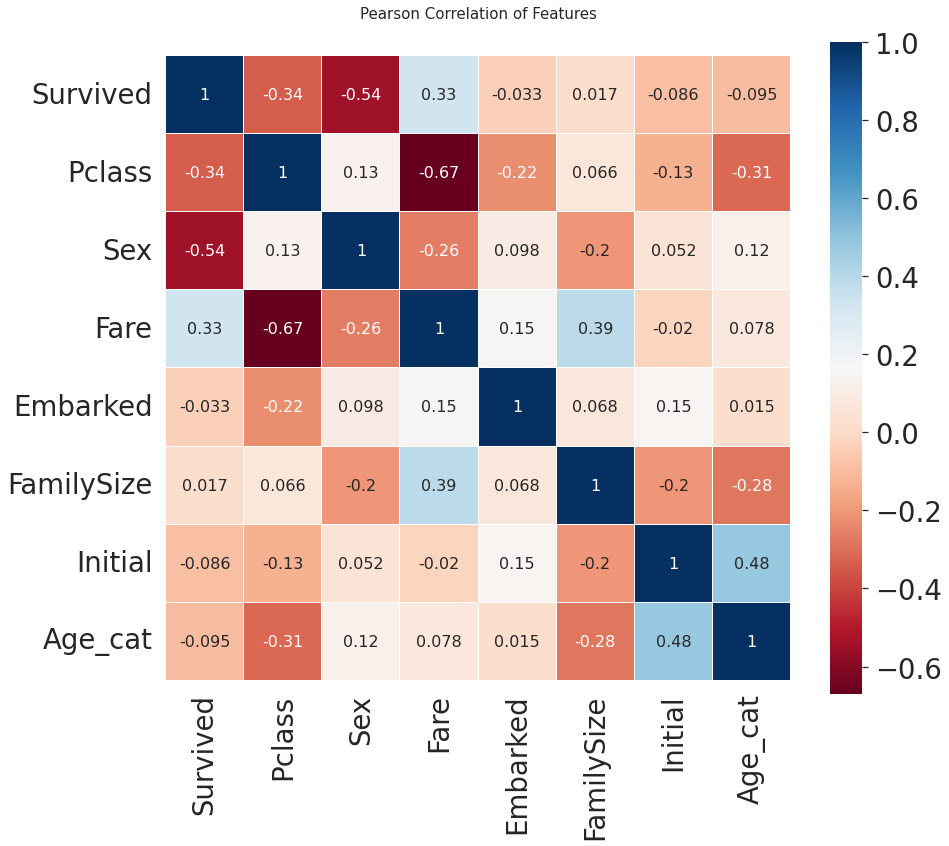

In [25]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

- Sex와 Pclass가 Survived에 상관관계가 어느정도 있음
- 생각보다 Fare와 Embarked 도 상관관계 있음
- 서로 강한 상관관계를 가지는 feature들이 없다...?
- 이것은 모델 학습시킬 떼, 불필요한 (redundant, superfluous) feature가 없다는 것을 의미
- 1또는 -1의 상관관계를 가진 feature A, B가 있다면 우리가 얻을 수 있는 정보는 하나일 것이기 때문


- 이제 실제 모델 학습 전 data preprocessing(전처리) 진행할 것

# 3.4 One-hot encoding on Initial and Embarked

- 수치화 : Master==0, Miss==1, Mr==2, Mrs==3, Other==4로 매핑해주는 것
- 수치화시킨 카테고리 데이터 그대로 넣어도 됨
- 모델의 성능을 높이기 위해 one-hot encoding 해줄 것
- One-hot encoding은 위 카테고리를 (0,1)로 이루어진 5차원의 벡터로 나타내는 것
  -> 이 작업은 pandas의 get_dummies를 사용하여 할 수 있음 
- 총 5개의 카테고리이니, one-hot encoding을 하면 새로운 5개의 column이 생긴다.
- Initial을 prefix로 두어서 구분이 쉽게 만든다.

In [26]:
df_train = pd.get_dummies(df_train, columns =  ['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns =  ['Initial'], prefix='Initial')

In [27]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2.0,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,NaN,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2.0,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2.0,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2.0,1,3,0,0,1,0,0


- 오른쪽에 one-hot encoded columns가 생성됨.

- Embarked에도 적용해보자

In [28]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

- sklearn으로 Labelencoder + OneHotencoder 을 이용해도 one-hot encoding 가능

# 3.5 Drop colums

- 이제 필요한 columns만 남기고 다 지운다.

In [29]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [30]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_1.0,Embarked_2.0
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,1


In [31]:
df_test.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_1.0,Embarked_2.0
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,1


- train의 Survived feature(targer class)를 빼면 train, test 둘 다 같은 칼럼들을 가짐.

# **4. Building machine learning model and prediction using the trained model**

- sklearn을 사용해 머신러닝 모델을 만들어보자

In [32]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier #유명한 randomforestclassfier이다.
from sklearn import metrics #모델의 평가를 위해 쓰인다.
from sklearn.model_selection import train_test_split #training set을 쉽게 나눠주는 함수이다.

- Sklearn : feature engineering, preprocessing, 지도 학습 알고리즘, 비지도 학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있음 // 데이터 분석 + 머신러닝 -> 이 라이브러리 필수 숙지


- 타이타닉 문제 : target class(survived) 존재 + target class 0, 1 로 이루어짐 --> binary classification 문제
- train set의 survived 제외한 것이 input -> 모델 최적화시켜 각 샘플(탑승객)의 생존 유무 판달 모델
- test set을 input -> test set의 각 샘플(탑승객)의 생존 유무 예측해보자.

# 4.1 Preparation - Split dataset into train, valid and test set

- 학습에 쓰일 데이터와 target label(survived)를 분리 --> **drop** 사용

In [33]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

- 좋은 모델을 위해 valid set도 따로 만들자 (train, test)
- train_test_split -> train set 쉽게 분리 가능

In [34]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

- sklearn : http://scikit-learn.org/stable/supervised_learning.html#supervised-learning
- 여기서는 머신러닝 알고리즘 중 랜덤포레스트 모델 사용
- 랜덤포레스트 : 결정트리기반 모델 / 여러 결정 트리들을 앙상블한 모델
- 랜덤포레스트 분류기 파라미터들 : n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등  -> 얘네를 어떻게 세팅되냐에 따라 데이터셋 같아도 모델의 성능 달라짐
- 파라미터 튜닝 : 시간, 경험, 알고리즘에 대한 이해 등이 필요 / 결국 많이 써봐야 모델도 잘 세울 수 있음
- but 튜토리얼이니까 파라미터 튜닝X / 기본 default 세팅으로 진행할 것
- 모델 객체 만들고, fit 메소드로 학습시킴
- 그 후 valid set input을 넣어 예측값(X_vld sample(탑승객)의 생존여부)를 얻는다.

# 4.2 Model generation and prediction

In [35]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

- 이 세 줄로 모델 세우고, 예측까지 한 것
- 모델의 성능을 알아보자

In [36]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100*metrics.accuracy_score(prediction, y_vld)))

총 268명 중 83.21% 정확도로 생존을 맞춤


# 4.3 Feature importance

- 학습된 모델은 feature importance를 가지게 됨.
- feature importance 통해 모델이 어떤 feature에 영향을 많이 받았는지 확인 가능
- pandas series 이용하면 쉽게 sorting 하여 그래프 그릴 수 있다.

In [37]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

ValueError: ignored

In [ ]:
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

- Fare, Initial_2, Age_cat 순으로 모델에 영향력을 가진다.
- 다른 모델 사용하면 feature importance 다르게 나올 수 있음
- feature importance --> feature selection : 좀 더 정확도 높은 모델을 얻기 위해 // feature 제거 : 좀 더 빠른 모델을 위해

# 4.4 Prediction on Test set

- test set(모델이 학습하지 않았던 정보)으로 생존여부 예측해보자.
- 캐글에서 준 파일, gender_submisson.csv 파일을 읽어서 제출 준비하기

In [ ]:
submission = pd.read_csv('/content/gdrive/MyDrive/kaggle/week1/gender_submission.csv')

In [ ]:
submission.head()

- test set에 대해 예측하고, 결과를 csv 파일로 저장해보자

In [ ]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [ ]:
submission.to_csv('/content/gdrive/MyDrive/kaggle/week1/my_first_submission.csv', index=False)

# **Conclusion**